In [1]:
#!python3 -c 'import tensorflow as tf; print(tf.__version__)'  # for Python 3

In [2]:
cd /content/drive/MyDrive/Colab Notebooks/BiLSTM-phantichbinhluan

/content/drive/MyDrive/Colab Notebooks/BiLSTM-phantichbinhluan


In [3]:
!pip install pyvi

     |████████████████████████████████| 8.5 MB 5.4 MB/s 
     |████████████████████████████████| 743 kB 39.7 MB/s 


In [4]:
!pip install underthesea==1.3.1

     |████████████████████████████████| 7.5 MB 4.6 MB/s 
     |████████████████████████████████| 753.2 MB 10 kB/s 
     |████████████████████████████████| 1.3 MB 38.6 MB/s 
     |████████████████████████████████| 235 kB 43.0 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 2.9 MB 34.3 MB/s 
     |████████████████████████████████| 1.1 MB 33.6 MB/s 
     |████████████████████████████████| 895 kB 34.7 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=638f929f862074d46aaa2d96d87b53c4df17e8c9d21f501b4538241b1b8a5963
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages 

In [5]:
import os
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
# from pyvi import ViTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np 
import re
import string
import codecs

#vocab_size = 15000 #cũ
#vocab_size = 9000 # cũ 2
vocab_size = 49000         ############################################### 
embedding_dim = 128 #cũ
#embedding_dim = 300
#max_length = 150 #cũ
max_length = 300
trunc_type='post'
padding_type='pre'
oov_tok = "<OOV>"
#training_size = 18000
training_size = 40000    ##############################################################
#training_size = 8000 #cũ 2
#training_size = 12869 #cũ
num_epochs= 30



from underthesea import word_tokenize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding,SimpleRNN,LSTM,Bidirectional, Dropout
from underthesea.word_tokenize.regex_tokenize import tokenize

def normalize_text(text):

        #Loại bỏ các ký tự kéo dài: vd: hayyyyyyy
        text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)

        # Chuyển các chữ hoa thành chữ thường
        text = text.lower()

        #Chuẩn hóa tiếng Việt, tiếng Anh, xử lý emoj
        replace_list = {
            'òa': 'oà', 'óa': 'oá', 'ỏa': 'oả', 'õa': 'oã', 'ọa': 'oạ', 'òe': 'oè', 'óe': 'oé','ỏe': 'oẻ',
            'õe': 'oẽ', 'ọe': 'oẹ', 'ùy': 'uỳ', 'úy': 'uý', 'ủy': 'uỷ', 'ũy': 'uỹ','ụy': 'uỵ', 'uả': 'ủa',
            'ả': 'ả', 'ố': 'ố', 'u´': 'ố','ỗ': 'ỗ', 'ồ': 'ồ', 'ổ': 'ổ', 'ấ': 'ấ', 'ẫ': 'ẫ', 'ẩ': 'ẩ',
            'ầ': 'ầ', 'ỏ': 'ỏ', 'ề': 'ề','ễ': 'ễ', 'ắ': 'ắ', 'ủ': 'ủ', 'ế': 'ế', 'ở': 'ở', 'ỉ': 'ỉ',
            'ẻ': 'ẻ', 'àk': u' à ','aˋ': 'à', 'iˋ': 'ì', 'ă´': 'ắ','ử': 'ử', 'e˜': 'ẽ', 'y˜': 'ỹ', 'a´': 'á',
            #Quy các icon về 2 loại emoj: Tích cực hoặc tiêu cực
            "👹": "negative", "👻": "positive", "💃": "positive",'🤙': ' positive ', '👍': ' positive ',
            "💄": "positive", "💎": "positive", "💩": "positive","😕": "negative", "😱": "nagetive", "😸": "positive",
            "😾": "negative", "🚫": "negative",  "🤬": "negative","🧚": "positive", "🧡": "positive",'🐶':' positive ',
            '👎': ' negative ', '😣': ' negative ','✨': ' positive ', '❣': ' positive ','☀': ' positive ',
            '♥': ' positive ', '🤩': ' positive ', 'like': ' positive ', '💌': ' positive ',
            '🤣': ' positive ', '🖤': ' positive ', '🤤': ' positive ', ':(': ' negative ', '😢': ' negative ',
            '❤': ' positive ', '😍': ' positive ', '😘': ' positive ', '😪': ' negative ', '😊': ' positive ',
            '?': ' ? ', '😁': ' positive ', '💖': ' positive ', '😟': ' negative ', '😭': ' negative ',
            '💯': ' positive ', '💗': ' positive ', '♡': ' positive ', '💜': ' positive ', '🤗': ' positive ',
            '^^': ' positive ', '😨': ' negative ', '☺': ' positive ', '💋': ' positive ', '👌': ' positive ',
            '😖': ' negative ', '😀': ' positive ', ':((': ' negative ', '😡': ' negative ', '😠': ' negative ',
            '😒': ' negative ', '🙂': ' positive ', '😏': ' negative ', '😝': ' positive ', '😄': ' positive ',
            '😙': ' positive ', '😤': ' negative ', '😎': ' positive ', '😆': ' positive ', '💚': ' positive ',
            '✌': ' positive ', '💕': ' positive ', '😞': ' negative ', '😓': ' negative ', '️🆗️': ' positive ',
            '😉': ' positive ', '😂': ' positive ', ':v': '  positive ', '=))': '  positive ', '😋': ' positive ',
            '💓': ' positive ', '😐': ' negative ', ':3': ' positive ', '😫': ' negative ', '😥': ' negative ',
            '😃': ' positive ', '😬': ' 😬 ', '😌': ' 😌 ', '💛': ' positive ', '🤝': ' positive ', '🎈': ' positive ',
            '😗': ' positive ', '🤔': ' negative ', '😑': ' negative ', '🔥': ' negative ', '🙏': ' negative ',
            '🆗': ' positive ', '😻': ' positive ', '💙': ' positive ', '💟': ' positive ',
            '😚': ' positive ', '❌': ' negative ', '👏': ' positive ', ';)': ' positive ', '<3': ' positive ',
            '🌝': ' positive ',  '🌷': ' positive ', '🌸': ' positive ', '🌺': ' positive ',
            '🌼': ' positive ', '🍓': ' positive ', '🐅': ' positive ', '🐾': ' positive ', '👉': ' positive ',
            '💐': ' positive ', '💞': ' positive ', '💥': ' positive ', '💪': ' positive ',
            '💰': ' positive ',  '😇': ' positive ', '😛': ' positive ', '😜': ' positive ',
            '🙃': ' positive ', '🤑': ' positive ', '🤪': ' positive ','☹': ' negative ',  '💀': ' negative ',
            '😔': ' negative ', '😧': ' negative ', '😩': ' negative ', '😰': ' negative ', '😳': ' negative ',
            '😵': ' negative ', '😶': ' negative ', '🙁': ' negative ',

            #Chuẩn hóa 1 số sentiment words/English words
            ':))': '  positive ', ':)': ' positive ','⭐': 'star ', '*': 'star ', '🌟': 'star ', '🎉': u' positive ',' vl ': ' negative ',
            'kg ': u' không ','not': u' không ', u' kg ': u' không ',' kh ':u' không ','kô':u' không ','ko':u' không ','hok':u' không ',
            ' kp ': u' không phải ',u' kô ': u' không ', '"ko ': u' không ', u' ko ': u' không ', u' k ': u' không ', 'khong': u' không ', u' hok ': u' không ',
            'he he': ' positive ','hehe': ' positive ','hihi': ' positive ', 'haha': ' positive ', 'hjhj': ' positive ',
            ' lol ': ' negative ',' cc ': ' negative ','cute': u' dễ thương ','huhu': ' negative ', ' vs ': u' với ', 'wa': ' quá ', 'wá': u' quá', 'j': u' gì ', '“': ' ',
            ' sz ': u' cỡ ', 'size': u' cỡ ', u' đx ': u' được ', 'dk': u' được ', 'dc': u' được ', 'đk': u' được ',
            'đc': u' được ', 'gud': u' tốt ','god': u' tốt ','wel done':' tốt ', 'good': u' tốt ', 'gút': u' tốt ',
            'sấu': u' xấu ','gut': u' tốt ', u' tot ': u' tốt ', u' nice ': u' tốt ', 'perfect': 'rất tốt', 'bt': u' bình thường ',
            'time': u' thời gian ', 'qá': u' quá ', u' m ': u' mình ', u' mik ': u' mình ',
            'ể': 'ể', 'excellent': 'xuất sắc', 'quality': 'chất lượng','chat':' chất ', 'excelent': 'hoàn hảo', 'bad': 'tệ','sad': ' tệ ',
            'shit': u' dở ẹt ',u' zị ': u' vậy ','beautiful': u' đẹp tuyệt vời ',u'bjo':u' bao giờ ',
            'thik': u' thích ',' fb ': ' facebook ', ' face ': ' facebook ', ' very ': u' rất ',
            'dep': u' đẹp ',u' xau ': u' xấu ','nice': u' hay ', u'qủa': u' quả ',
            'iu': u' yêu ','fake': u' giả mạo ', '><': u' positive ',
            ' por ': u' tệ ',' poor ': u' tệ ',
            #dưới 3* quy về 1*, trên 3* quy về 5*
            '6 sao': ' 5star ','6 star': ' 5star ', '5star': ' 5star ','5 sao': ' 5star ','5sao': ' 5star ',
            'starstarstarstarstar': ' 5star ', '1 sao': ' 1star ', '1sao': ' 1star ','2 sao':' 1star ','2sao':' 1star ',
            '2 starstar':' 1star ','1star': ' 1star ', '0 sao': ' 1star ', '0star': ' 1star ', '?': '','.': '',',': '',}
        for k, v in replace_list.items():
            text = text.replace(k, v)
        #remove nốt những ký tự thừa thãi
        text = text.replace(u'"', u' ')
        text = text.replace(u'️', u'')
        text = text.replace('🏻','')
        text = word_tokenize(text, format="text")
        return text



def replace_list(text):
  replace_list = {':))': '  positive ', ':)': ' positive ','⭐': 'star ',
  '*': 'star ', '🌟': 'star ',
  '🎉': u' positive ',' vl ': ' negative ',
  'kg ': u' không ','not': u' không ', u' kg ': u' không ',' kh ':u' không ',
  'kô':u' không ','ko':u' không ','hok':u' không ',
  ' kp ': u' không phải ',u' kô ': u' không ', '"ko ': u' không ',
  u' ko ': u' không ', u' k ': u' không ',
 'khong': u' không ', u' hok ': u' không ',
  'he he': ' positive ','hehe': ' positive ','hihi': ' positive ',
  'haha': ' positive ', 'hjhj': ' positive ',}
  for k, v in replace_list.items():
            text = text.replace(k, v)
  return text

def clean(text):
  return word_tokenize(normalize_text(text), format="text")
review = 'phim không hài hước gì cả 🙁'
s= clean(review)
print(s)

t = Tokenizer(num_words=10, oov_token=oov_tok)
t.fit_on_texts([s])
#t  = Tokenizer()
# text_text=[s]
# t.fit_on_texts(text_text)
print("word_index : ",t.word_index)


phim không hài_hước gì cả negative
word_index :  {'<OOV>': 1, 'phim': 2, 'không': 3, 'hài': 4, 'hước': 5, 'gì': 6, 'cả': 7, 'negative': 8}


In [6]:
class DataSource(object):

    def _load_raw_data(self, filename, is_train=True):

        a = []
        b = []

        regex = 'train_'
        if not is_train:
            regex = 'test_'

        with open(filename, 'r') as file:
            for line in file:
                if regex in line:
                    b.append(a)
                    a = [line]
                elif line != '\n': ######################
                    a.append(line)
        b.append(a)

        return b[1:]

    def _create_row(self, sample, is_train=True):

        d = {}
        d['id'] = sample[0].replace('\n', '') #############
        review = ""

        if is_train:
            for clause in sample[1:-1]:
                review += clause.replace('\n', ' ')#############
                review = review.replace('.', ' ')

            d['label'] = int(sample[-1].replace('\n', ' '))#############
        else:
            for clause in sample[1:]:
                review += clause.replace('\n', ' ')#############
                review = review.replace('.', ' ')


        d['review'] = review

        return d

    def load_data(self, filename, is_train=True):

        raw_data = self._load_raw_data(filename, is_train)
        lst = []

        for row in raw_data:
            lst.append(self._create_row(row, is_train))

        return lst

    def transform_to_dataset(self, x_set,y_set):
        X, y = [], []
        for document, topic in zip(list(x_set), list(y_set)):
            document = normalize_text(document)
            X.append(document.strip())
            y.append(topic)
            X.append(no_marks(document))
            y.append(topic)
        return X, y



In [7]:
ds = DataSource()
train_data = pd.DataFrame(ds.load_data('tmp/dataset50k.crash')) ##################################################################

train_data.shape
train_data

,id,label,review
0,train_000000,1,"""Trước hết tôi muốn nói rằng tôi dựa vào tự do..."
1,train_000001,1,"""Tôi rất vui mừng khi thấy một bộ phim sitcom ..."
2,train_000002,1,"""Khi bạn nhìn vào trang bìa và đọc nội dung về..."
3,train_000003,1,"""Giống như nhiều người khác, tôi đã đếm được s..."
4,train_000004,1,"""Bộ phim này đã có mặt trên TV vào một ngày kh..."
...,...,...,...
49995,train_49995,0,"""Đây là một bộ phim hài tuyệt vời với một diễn..."
49996,train_49996,0,"""Không có cốt truyện Không có nhân vật trung ..."
49997,train_49997,0,"""Chương trình này là tuyệt vời! Tôi yêu tất cả..."
49998,train_49998,1,"""Thực tế là bộ phim này đã được hưởng bộ phim ..."


In [8]:
sentences = []
labels = []
for index,item in train_data.iterrows():
  sentences.append(normalize_text(item['review']))
  labels.append(item['label'])
import numpy as np
labels = np.array(labels)

newsentence = []

for v in sentences:
  newsentence.append(clean(v))

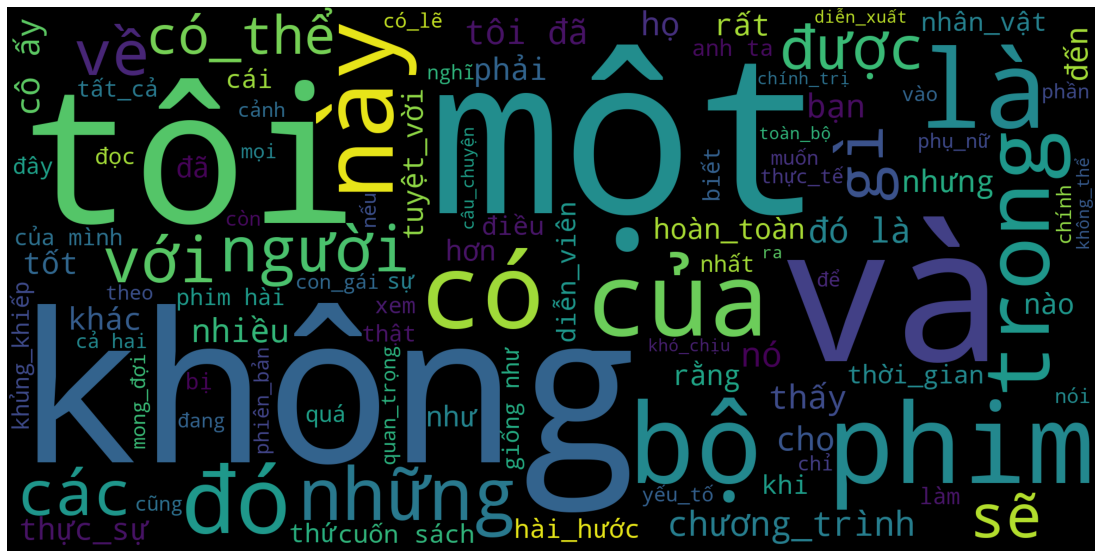

In [9]:
# Commented out IPython magic to ensure Python compatibility.
import wordcloud
import matplotlib.pyplot as plt
# %matplotlib inline
cloud = np.array(newsentence).flatten()
plt.figure(figsize=(20,10))
word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(str(cloud))
plt.axis("off")
plt.imshow(word_cloud)

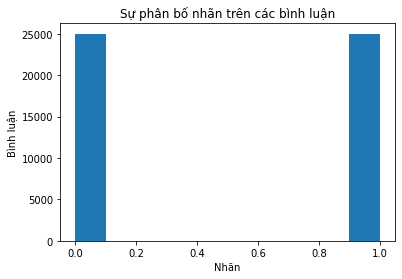

In [10]:
import matplotlib.pyplot as plt
x = labels
plt.xlabel("Nhãn")
plt.ylabel("Bình luận")
plt.title("Sự phân bố nhãn trên các bình luận")
plt.hist(x);

In [11]:
token =[]
for text in sentences:
 token.append(word_tokenize(normalize_text(text),format="text"))

token_sentences = token
# Chia  tập train
training_sentences = token[0:training_size]
#  Chia tập test
testing_sentences = token[training_size:]
#  Chia tập train
training_labels = labels[0:training_size]
#  Chia tập test
testing_labels = labels[training_size:]

#  Tạo tokenizer
tokenizer = Tokenizer(num_words=vocab_size ,filters='', oov_token= oov_tok)
#  Đưa từ vào tokenizer để tạo từ điển
tokenizer.fit_on_texts(token_sentences)
#  Biến các câu train thành sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
# Padding cho các train sequences
training_padded = pad_sequences(training_sequences, maxlen= max_length , padding= padding_type , truncating=trunc_type)
# Biến các câu test thành sequences và padding tương ứng
test_sequences = tokenizer.texts_to_sequences(testing_sentences)
test_padded = pad_sequences(test_sequences, maxlen= max_length , padding= padding_type , truncating= trunc_type)

def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = npx.sigmoid(np.dot(X, W_xi) + np.dot(H, W_hi) + b_i)
        F = npx.sigmoid(np.dot(X, W_xf) + np.dot(H, W_hf) + b_f)
        O = npx.sigmoid(np.dot(X, W_xo) + np.dot(H, W_ho) + b_o)
        C_tilda = np.tanh(np.dot(X, W_xc) + np.dot(H, W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * np.tanh(C)
        Y = np.dot(H, W_hq) + b_q
        outputs.append(Y)
    return np.concatenate(outputs, axis=0), (H, C)

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
# Xây dựng model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length= max_length))
# model1.add(GlobalAveragePooling1D(4))
#model.add(Bidirectional(LSTM(128))) #2LSTM(128)  4* ((size_input * 1)* size_out_put + size_out*2 ) x 2 
model.add(LSTM(128))  #####################################################################################################
# model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))    ####v
#model.add(Dense(32, activation='relu'))  ####^
model.add(Dense(16, activation='relu'))
# Thêm một lớp Dense cuối
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          6272000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 6,429,409
Trainable params: 6,429,409
Non-trainable params: 0
______________________________________________

In [13]:
#  Compile 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])# metrics=['acc',f1_m,precision_m, recall_m])
model.fit(training_padded, training_labels ,validation_split=0.2, epochs=10  , validation_data=(test_padded, testing_labels)) #cũ validation_split=0.3

Epoch 1/10
1000/1000 [==============================] - 86s 76ms/step - loss: 0.5461 - acc: 0.7301 - val_loss: 0.4654 - val_acc: 0.8120
Epoch 2/10
1000/1000 [==============================] - 69s 69ms/step - loss: 0.4075 - acc: 0.8275 - val_loss: 0.5037 - val_acc: 0.7857
Epoch 3/10
1000/1000 [==============================] - 70s 70ms/step - loss: 0.3029 - acc: 0.8764 - val_loss: 0.3835 - val_acc: 0.8307
Epoch 4/10
1000/1000 [==============================] - 69s 69ms/step - loss: 0.1946 - acc: 0.9270 - val_loss: 0.3594 - val_acc: 0.8553
Epoch 5/10
1000/1000 [==============================] - 69s 69ms/step - loss: 0.1358 - acc: 0.9534 - val_loss: 0.4458 - val_acc: 0.8649
Epoch 6/10
1000/1000 [==============================] - 70s 70ms/step - loss: 0.0937 - acc: 0.9689 - val_loss: 0.4960 - val_acc: 0.8549
Epoch 7/10
1000/1000 [==============================] - 69s 69ms/step - loss: 0.0710 - acc: 0.9757 - val_loss: 0.5799 - val_acc: 0.8569
Epoch 8/10
1000/1000 [==========================

Lưu mô hình train BiLSTM và tách từ tokenziner

In [14]:
y_label = testing_labels
y_pred = model.predict(test_padded )
y_pred = np.round(y_pred)

from sklearn.metrics import accuracy_score
accuracy_score(y_label, y_pred)
print("Độ chính xác của Accuracy_score là ",accuracy_score(y_label, y_pred)*100,"%")

from sklearn.metrics import f1_score
f1_score(y_label, y_pred)



from sklearn.metrics import precision_score
precision_score(y_label, y_pred)



from sklearn.metrics import recall_score
recall_score(y_label, y_pred)
print("|  Precision  |  Recall   |   F1    |")

print("| ",precision_score(y_label, y_pred)*100,"% |  ",recall_score(y_label, y_pred)*100,"%   |",f1_score(y_label, y_pred)*100,"%  |")




Độ chính xác của Accuracy_score là  84.26 %
|  Precision  |  Recall   |   F1    |
|  86.29185091598231 % |   81.61720772754431 %   | 83.88945752302969 %  |


In [15]:
import pickle
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer_tmp = pickle.load(handle)

model.save('my_model.h5')

Test câu "phim hay"

In [16]:
test=[]
test_sen = "phim hay"
test.append(word_tokenize(normalize_text(test_sen),format="text"))
# Chuyển câu thành Sequences
test_sen_sequences = tokenizer.texts_to_sequences(test)
# padding 
padded_test_sen_sequences = pad_sequences(test_sen_sequences, maxlen= max_length , padding= padding_type , truncating= trunc_type)
# dự đoán
a= model.predict(padded_test_sen_sequences)
l = a.tolist()
list = [round(x[0]) for x in l]
if list[0]==1 :
  print(test_sen)
  print('=>Tiêu cực')
else:
  print(test_sen)
  print('=>Tích cực')
###

phim hay
=>Tiêu cực


Test câu "phim chán"

In [17]:
#thử với 1 câu để kiểm tra
test_sen = "phim chán"
test=[]
test.append(word_tokenize(normalize_text(test_sen),format="text"))
# Chuyển câu thành Sequences
test_sen_sequences = tokenizer.texts_to_sequences(test)
# padding 
padded_test_sen_sequences = pad_sequences(test_sen_sequences, maxlen= max_length , padding= padding_type , truncating= trunc_type)
# dự đoán
a= model.predict(padded_test_sen_sequences)
l = a.tolist()
list = [round(x[0]) for x in l]
if list[0]==1 :
  print(test_sen)
  print('=>Tiêu cực')
else:
  print(test_sen)
  print('=>Tích cực')

phim chán
=>Tiêu cực


In [19]:
# Load lại model
new_model = tf.keras.models.load_model('my_model.h5')
# Hiển thị kiến trúc
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          6272000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 6,429,409
Trainable params: 6,429,409
Non-trainable params: 0
______________________________________________